In [1]:
import torch
import cv2
from segmentation_models_pytorch import Unet
import os
from card_segmentation.utils import image
import numpy as np
import matplotlib.pyplot as plt

c:\Users\ADMIN\anaconda3\envs\card_classification\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_PATH = "card_segmentation/pretrained/model_final.pt"
DATA_PATH  = "data/MIDV500/"
DATABASE   = "database/"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
model = Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint)
model.to(device)
model.eval()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24252\3784669547.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH)


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [5]:
def predict_image(model, image):
    with torch.no_grad():
        output = model(image.to(device))

    output = output.detach().cpu().numpy()[0]
    output = output.transpose((1, 2, 0))
    output = np.uint8(output)
    _, output = cv2.threshold(output, 127, 255, cv2.THRESH_BINARY_INV)

    return output

In [6]:
def crop_image(image_dir):
    img, w, h = image.load_image(image_dir)
    mask = predict_image(model, img)
    mask = cv2.resize(mask, (w, h))
    raw_image = cv2.imread(image_dir)
    warped = image.extract_idcard(raw_image, mask)
    return warped

In [7]:
segment_failed = []
image_list = []

In [8]:
PREDICTION = "prediction/"

In [9]:
each_label = []

In [10]:
for i in range(len(os.listdir(DATA_PATH))):
    img_list = []
    image_dir = DATA_PATH + str(i+1) + '/'
    cnt = 0
    for img in os.listdir(image_dir):
        img_dir = image_dir + '/' + img
        warped_img = crop_image(img_dir)
        if warped_img is not None:
            warped_img = cv2.resize(warped_img, (256, 256))
            img_list.append(warped_img)
            cv2.imwrite(PREDICTION + img, warped_img)
            if cnt==0:
                each_label.append(warped_img)
            cnt+=1
        else:
            segment_failed.append(img_dir)
    
    image_list.append(img_list)

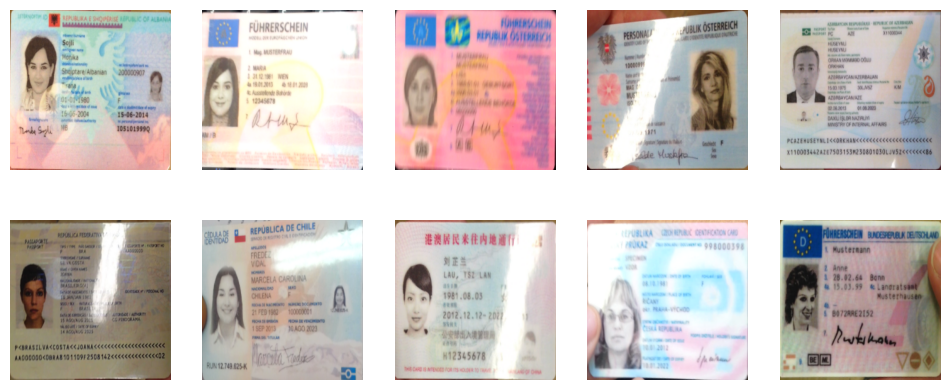

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, img_lst in enumerate(each_label):
    axes[i//5, i%5].imshow(each_label[i])
    axes[i//5, i%5].axis('off')

plt.show()

In [12]:
len(segment_failed)

6

In [13]:
image_list[0][0].shape

(256, 256, 3)

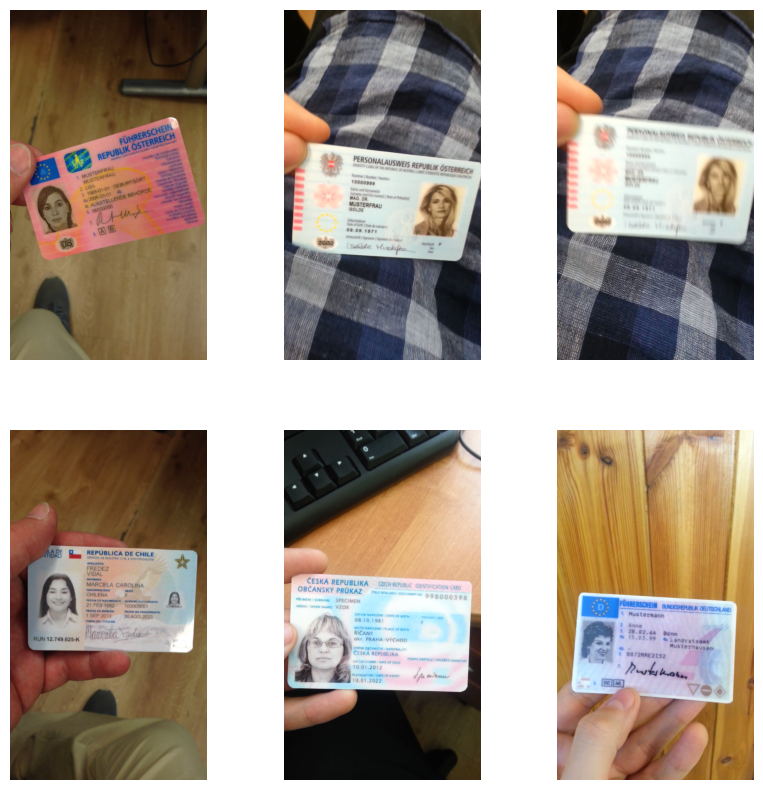

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10))

for i, img_dir in enumerate(segment_failed):

    axes[i//3, i%3].imshow(cv2.cvtColor(cv2.imread(img_dir), cv2.COLOR_BGR2RGB))
    axes[i//3, i%3].axis('off')

plt.show()

In [15]:
min_distance = 10000

database/1.png
database/2.png
database/3.png
database/4.png
database/5.png
database/6.png
database/7.png
database/8.png
database/9.png
database/10.png


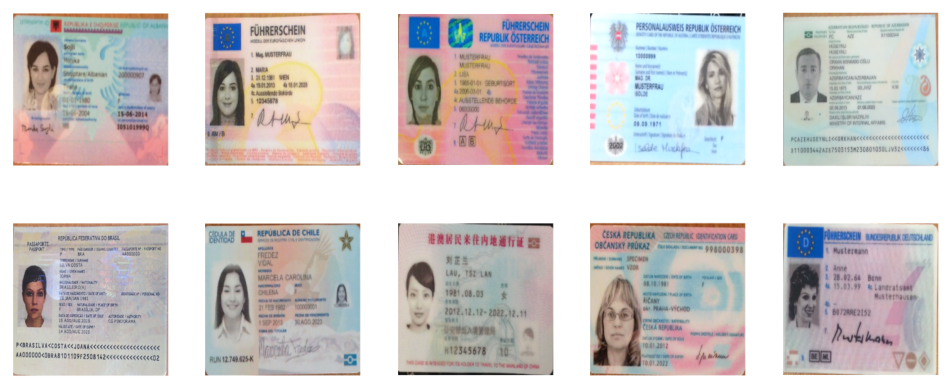

In [35]:
database_img = []
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(len(os.listdir(DATABASE))):
    label = DATABASE + str(i+1) + '.png'
    print(label)
    img = cv2.imread(label)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    database_img.append(img)

    axes[i//5, i%5].imshow(img)
    axes[i//5, i%5].axis('off')

plt.show()

In [17]:
import numpy as np

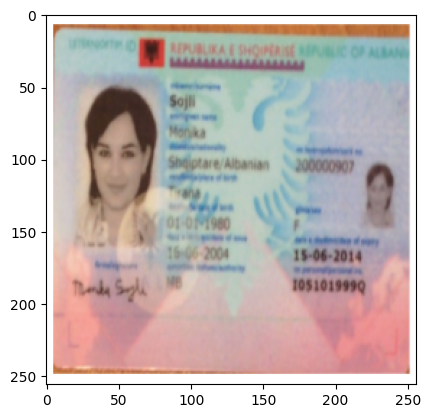

In [18]:
plt.imshow(database_img[0])

In [19]:
failed = []
failed_cnt = 0
success_cnt = 0
for i in range(len(image_list)):
    print('class: ', i)
    f = []
    for j in range(len(image_list[i])):
        img = image_list[i][j]
        classification = 0
        score = np.zeros(len(database_img))
        for k in range(len(database_img)):
            temp = cv2.cvtColor(database_img[k], cv2.COLOR_BGR2RGB)
            temp = cv2.resize(temp, (256, 256))
            score[k] = cv2.matchTemplate(img, temp, cv2.TM_CCOEFF_NORMED)[0,0]
        
        print(score)
        min_distance = min(min_distance, np.max(score) - np.min(score))
        classification = np.argmax(score)
        print("classification: ", classification)

        if classification != i:
            failed_cnt += 1
            f.append(img)
        else:
            success_cnt += 1
    
    failed.append(f)


class:  0
[ 0.26207849  0.08439144  0.05989408  0.01639522  0.08150998  0.03683673
  0.0382359  -0.02092163 -0.05295752  0.07969403]
classification:  0
[ 0.1844656   0.04129644 -0.00565408 -0.0415107   0.01258021 -0.08491912
 -0.062228   -0.11259308 -0.08606805  0.03438134]
classification:  0
[ 0.10571724  0.04247922 -0.02325565 -0.02078339  0.00782013 -0.05088834
 -0.05626353 -0.11028507 -0.12103917  0.0087532 ]
classification:  0
[-0.09009961 -0.15277402 -0.25275591 -0.09294616 -0.17964359 -0.25154558
 -0.32060167 -0.29107642 -0.31198049 -0.19488549]
classification:  0
[ 0.25247476  0.10765958  0.04223177  0.00114744  0.09710851  0.01970463
  0.01309888 -0.02226682 -0.04576751  0.0899835 ]
classification:  0
[ 0.22107771  0.11898589  0.03707729  0.00378446  0.09247545  0.01627361
  0.00344559 -0.02104649 -0.05001955  0.09014664]
classification:  0
[ 0.25717929  0.14846084  0.08633711  0.00872334  0.12954269  0.05113331
  0.07197145 -0.02820769  0.00202639  0.11546235]
classification:

In [20]:
print(failed_cnt, success_cnt)

20 65


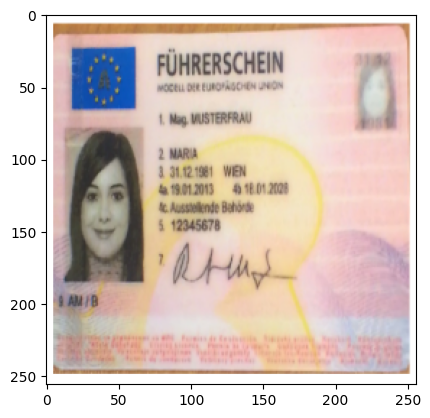

In [21]:
plt.imshow(database_img[1])

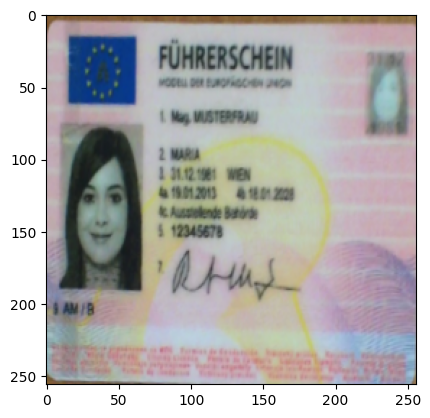

In [22]:
plt.imshow(image_list[1][2])

In [24]:
min_distance

0.1542557030916214

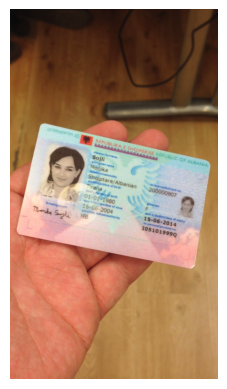

In [31]:
img = cv2.imread("image4.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(img)


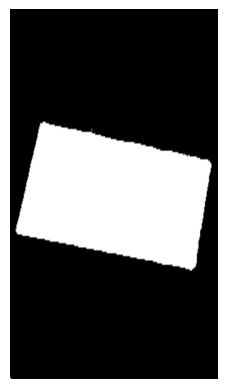

In [32]:
img, w, h = image.load_image("image4.png")
mask = predict_image(model, img)
mask = cv2.resize(mask, (w, h))

temp_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
plt.axis('off')
plt.imshow(temp_mask)

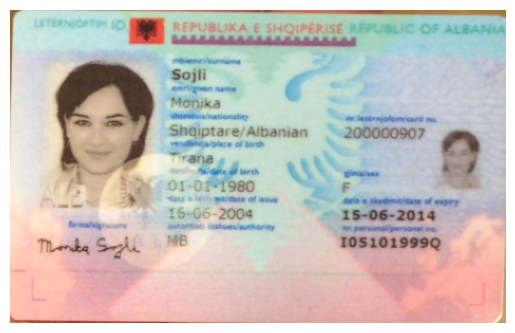

In [33]:
raw_image = cv2.imread("image4.png")
warped = image.extract_idcard(raw_image, mask)

plt.axis('off')
plt.imshow(warped)

In [34]:

img = raw_image
classification = 0
score = np.zeros(len(database_img))
for k in range(len(database_img)):
    temp = cv2.cvtColor(database_img[k], cv2.COLOR_BGR2RGB)
    temp = cv2.resize(temp, (256, 256))
    score[k] = cv2.matchTemplate(img, temp, cv2.TM_CCOEFF_NORMED)[0,0]

print(score)
min_distance = min(min_distance, np.max(score) - np.min(score))
classification = np.argmax(score)
print("classification: ", classification)

[ 0.13961209  0.01468662  0.16884212  0.05627787 -0.09276941  0.07790531
  0.01702638 -0.0438174  -0.07087363  0.137338  ]
classification:  2
